In [17]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
class SpeechData(torch.utils.data.Dataset):
    def __init__(self, device=DEVICE):
        self.device = device
        self.dataset = [
            "./samples/knn-vc-ablation/amazing_sound_1s.wav",
            "./samples/knn-vc-ablation/amazing_sound_3s.wav",
            "./samples/knn-vc-ablation/amazing_sound_5s.wav",
            "./samples/knn-vc-ablation/amazing_sound_10s.wav",
            "./samples/knn-vc-ablation/amazing_sound_15s.wav",
        ]
        self.text = "THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRAWLING AND CREEPING AROUND HER SHE HAD STRUGGLED IN DUMB SPEECHLESS TERROR AGAINST SOME MIGHTY GRASPING THAT STROVE FOR HER LIFE WITH GNARLED AND CREEPING FINGERS BUT NOW AT LAST WEAKLY SHE OPENED HER EYES AND QUESTIONED"
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        path = self.dataset[item]
        audio, sr = torchaudio.load(path)
        assert sr == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, self.text, audio)
    

In [28]:
loader = torch.utils.data.DataLoader(SpeechData(), batch_size=1)
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

Model is English-only and has 71,825,408 parameters.


In [29]:
hypotheses = []
references = []
from tqdm import tqdm
for mels, texts, audio in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


In [30]:
hypotheses

['The',
 "In that in where old Henry Stone's hidden pawling and creeping around her, she struggled in Stone's speechless terror against someone I did grasping his jaw for her life, was gnawled and creeping fingers, but now with last, briefly, she opened her eyes and questioned.",
 'In that in web of endless pains have been crawling and creeping around her, she has struggled in stone speechless terror against some mighty grasping that stroll for her life, was gnarled and creeping fingers, but now at last, weekly, she opened her eyes and questioned.',
 'In that in web of endless veins had been crawling and creeping around her, she struggled in bones speechless terror against some mighty grasping that stole for her life, was gnawled and creeping fingers, but now at last, weak weak, she opened her eyes and questioned.',
 'Then that in web of endless veins had been crawling and creeping around her, she had struggled in done speechless terror against somebody grasping this jaw for her life, 

In [22]:
references

['THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRAWLING AND CREEPING AROUND HER SHE HAD STRUGGLED IN DUMB SPEECHLESS TERROR AGAINST SOME MIGHTY GRASPING THAT STROVE FOR HER LIFE WITH GNARLED AND CREEPING FINGERS BUT NOW AT LAST WEAKLY SHE OPENED HER EYES AND QUESTIONED',
 'THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRAWLING AND CREEPING AROUND HER SHE HAD STRUGGLED IN DUMB SPEECHLESS TERROR AGAINST SOME MIGHTY GRASPING THAT STROVE FOR HER LIFE WITH GNARLED AND CREEPING FINGERS BUT NOW AT LAST WEAKLY SHE OPENED HER EYES AND QUESTIONED',
 'THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRAWLING AND CREEPING AROUND HER SHE HAD STRUGGLED IN DUMB SPEECHLESS TERROR AGAINST SOME MIGHTY GRASPING THAT STROVE FOR HER LIFE WITH GNARLED AND CREEPING FINGERS BUT NOW AT LAST WEAKLY SHE OPENED HER EYES AND QUESTIONED',
 'THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRAWLING AND CREEPING AROUND HER SHE HAD STRUGGLED IN DUMB SPEECHLESS TERROR AGAINST SOME MIGHTY GRASPING THAT STROVE FOR HER LIFE WITH GNARLED A

In [23]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,The,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...
1,In that in where old Henry Stone's hidden pawl...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...
2,In that in web of endless pains have been craw...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...
3,In that in web of endless veins had been crawl...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...
4,Then that in web of endless veins had been cra...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...


In [24]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,The,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...,the,the net and web of endless things had been cra...
1,In that in where old Henry Stone's hidden pawl...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...,in that in where old henry stone is hidden paw...,the net and web of endless things had been cra...
2,In that in web of endless pains have been craw...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...,in that in web of endless pains have been craw...,the net and web of endless things had been cra...
3,In that in web of endless veins had been crawl...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...,in that in web of endless veins had been crawl...,the net and web of endless things had been cra...
4,Then that in web of endless veins had been cra...,THE NET AND WEB OF ENDLESS THINGS HAD BEEN CRA...,then that in web of endless veins had been cra...,the net and web of endless things had been cra...


In [25]:
for i in range(5):
    wer = jiwer.wer(list(data["reference_clean"])[i], list(data["hypothesis_clean"])[i])

    print(f"WER: {wer * 100:.2f} %")

WER: 97.83 %
WER: 47.83 %
WER: 21.74 %
WER: 23.91 %
WER: 23.91 %


In [26]:
import torchaudio
import torch
from speechbrain.pretrained import EncoderClassifier
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb", run_opts={"device":"cuda"})
target_signal, fs =torchaudio.load('./audio/7729.wav')
target_signal_embeddings = classifier.encode_batch(target_signal).squeeze()
for mels, texts, audio in tqdm(loader):
    embedding = classifier.encode_batch(audio).squeeze()
    print(cos(embedding, target_signal_embeddings))

100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 72.30it/s]

tensor([ 0.9981, -0.9844,  0.9353,  0.9083,  0.9383,  0.9480,  0.9983,  0.9970,
         0.9981,  0.9997,  0.9964,  0.9978,  0.9990,  0.9635,  0.9934,  0.9975,
         0.8338,  0.9894,  0.9578, -0.9975,  0.9953,  0.9596,  0.9953,  0.9887,
         0.9954,  0.9746,  0.9962, -0.9790,  0.8314,  0.9283,  0.9997,  0.9971,
         0.9963,  0.6858,  0.9914,  0.9941,  0.9965,  0.9992, -0.9959,  0.9965,
         0.9994,  0.9944,  0.9959,  0.9996,  0.9948,  0.9970,  0.9976,  0.9999,
         0.9999,  0.9850,  0.9986,  0.9825,  0.9440, -0.0214,  0.9859, -0.9651,
         0.9589,  0.9983,  0.9990,  0.9460,  0.9738,  0.9969,  0.9973,  0.3082,
         0.9769,  0.9979,  0.7766,  0.9944,  0.9991,  0.9967,  0.9934,  0.9946,
        -0.9440,  0.9767,  0.9771,  0.9917,  0.9971,  0.9858,  0.9900,  0.9984,
         0.9978,  0.9979,  0.9980,  0.9986,  0.9974,  0.9953,  0.9976,  0.9990,
        -0.9984,  0.9936,  0.9983,  0.9972,  0.9645,  0.9972,  0.9983, -0.9882,
         0.9991,  0.9962,  0.9985,  0.99

In [85]:
from matplotlib import pyplot as plt
import matplotlib
from importlib import reload
plt.style.use('ggplot')
matplotlib=reload(matplotlib)
plt.figure(figsize=(6,4.5))
x = [1,3,5,10,15]
y1 = [17.39,15.22,17.39,19.57,19.57]
y2 = [97.83,47.83,21.74,23.91,23.91]
plt.subplot(211)
plt.plot(x,y1,'--bo', label="Phoneme Hallucinator (Ours)")
plt.plot(x,y2,'--r+', label="kNN-VC")
plt.ylabel("Word Error Rate")

plt.legend()
plt.xticks([])
plt.subplot(212)
y1 = [0.8077,0.8222,0.8203,0.8221,0.8241]
y2 = [0.7524,0.8235, 0.8255, 0.8242, 0.8263]
plt.plot(x,y1,'--bo', label="Phoneme Hallucinator (Ours)")
plt.plot(x,y2,'--r+', label="kNN-VC")
plt.xlabel("Target Voice Duration (s)")
plt.ylabel("Speaker Similarity (cos)")
plt.xticks(x)
#plt.legend()
plt.tight_layout()
plt.savefig("knn-vc-ablation.pdf",dpi=300)

In [16]:
import torchaudio
import torch
from speechbrain.pretrained import EncoderClassifier
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb", run_opts={"device":"cuda"})
target_signal, fs =torchaudio.load('./audio/7729_short.wav')
our_signal, fs =torchaudio.load('./amazing_sound.wav')
freevc_signal, fs =torchaudio.load('./freevc.wav')
target_signal_embeddings = classifier.encode_batch(target_signal).squeeze()
our_signal_embeddings = classifier.encode_batch(our_signal).squeeze()
freevc_signal_embeddings = classifier.encode_batch(freevc_signal).squeeze()
print(cos(our_signal_embeddings, target_signal_embeddings))
print(cos(freevc_signal_embeddings, target_signal_embeddings))

tensor(0.9423, device='cuda:0')
tensor(0.9309, device='cuda:0')


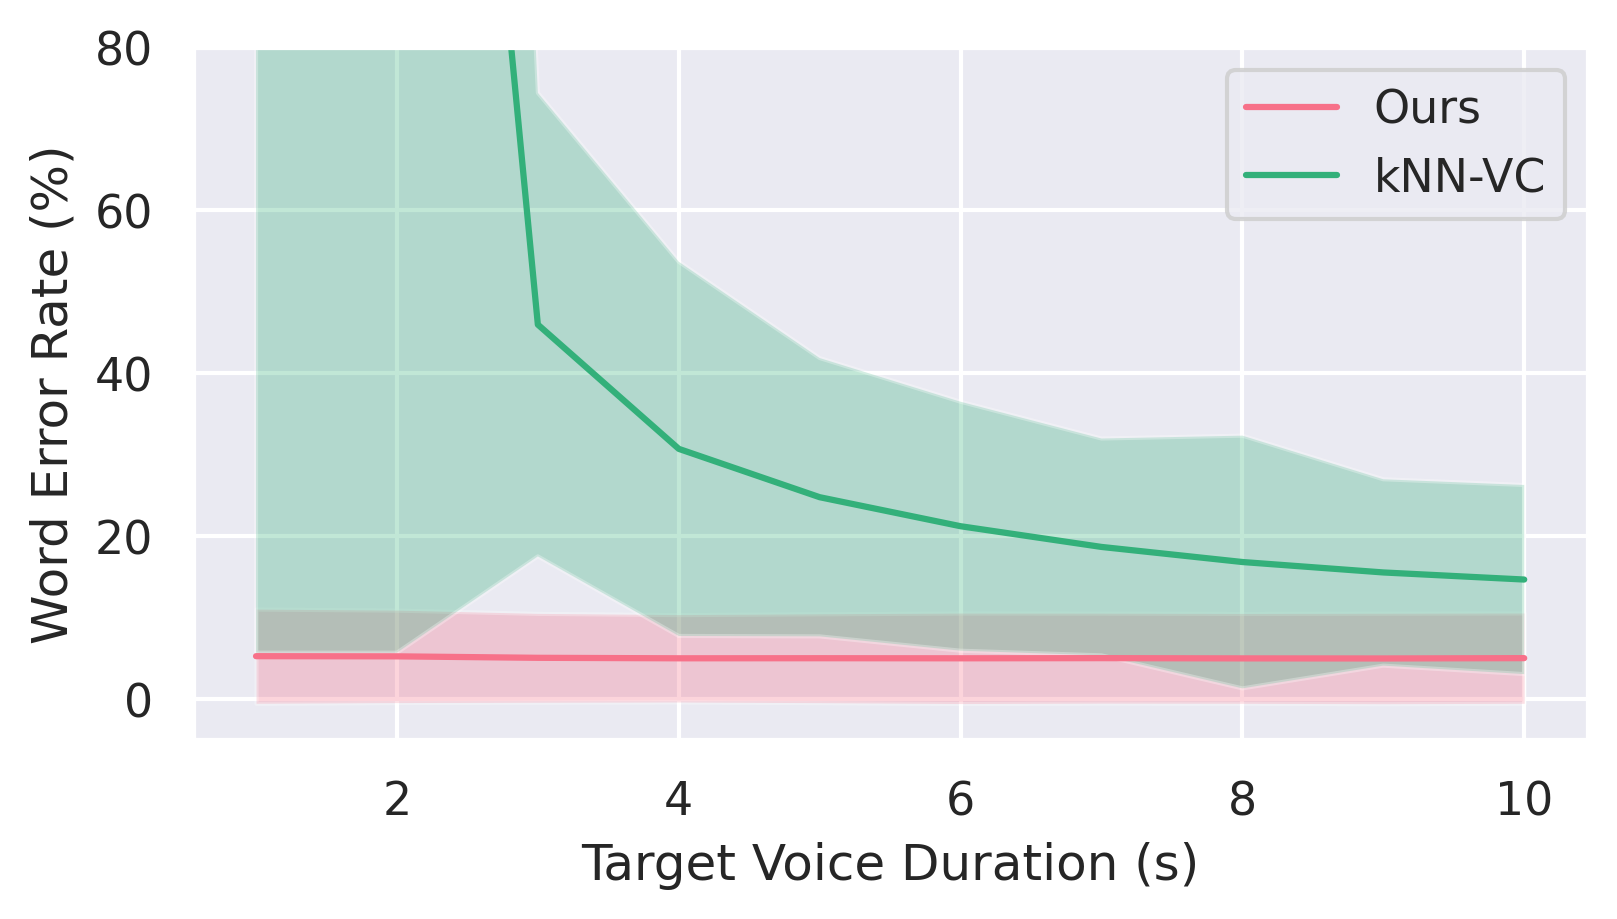

In [1]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sns.set(rc={'figure.figsize':(6,3),"figure.dpi":300, 'savefig.dpi':300})

fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
x = [1,2,3,4,5,6,7,8,9,10]
ours_wer_mean = np.array([5.25, 5.23, 5.05, 4.99, 5.00, 4.99, 5.01, 4.98, 4.97,5.01])
ours_wer_std = np.array([5.78, 5.67, 5.45, 5.36, 5.45, 5.55, 5.52, 5.51, 5.55,5.54])
unexpand_wer_mean = np.array([225.74,225.74,45.92,30.68, 24.75, 21.19, 18.65, 16.80, 15.52, 14.65])
unexpand_wer_std = np.array([220.06,220.06,28.43, 22.95, 17.07, 15.27, 13.30, 15.50, 11.43, 11.60])

with sns.axes_style("darkgrid"):
    ax.plot(x, ours_wer_mean, label="Ours", c=clrs[0])
    ax.fill_between(x, ours_wer_mean-ours_wer_std, ours_wer_mean+ours_wer_std ,alpha=0.3, facecolor=clrs[0])
    ax.plot(x, unexpand_wer_mean, label="kNN-VC", c=clrs[2])
    ax.fill_between(x, unexpand_wer_mean-unexpand_wer_std, unexpand_wer_mean+unexpand_wer_std ,alpha=0.3, facecolor=clrs[2])
    ax.legend()
    #ax.set_yscale('log')
    ax.set(xlabel='Target Voice Duration (s)', ylabel='Word Error Rate (%)', ylim=(-5, 80))
    



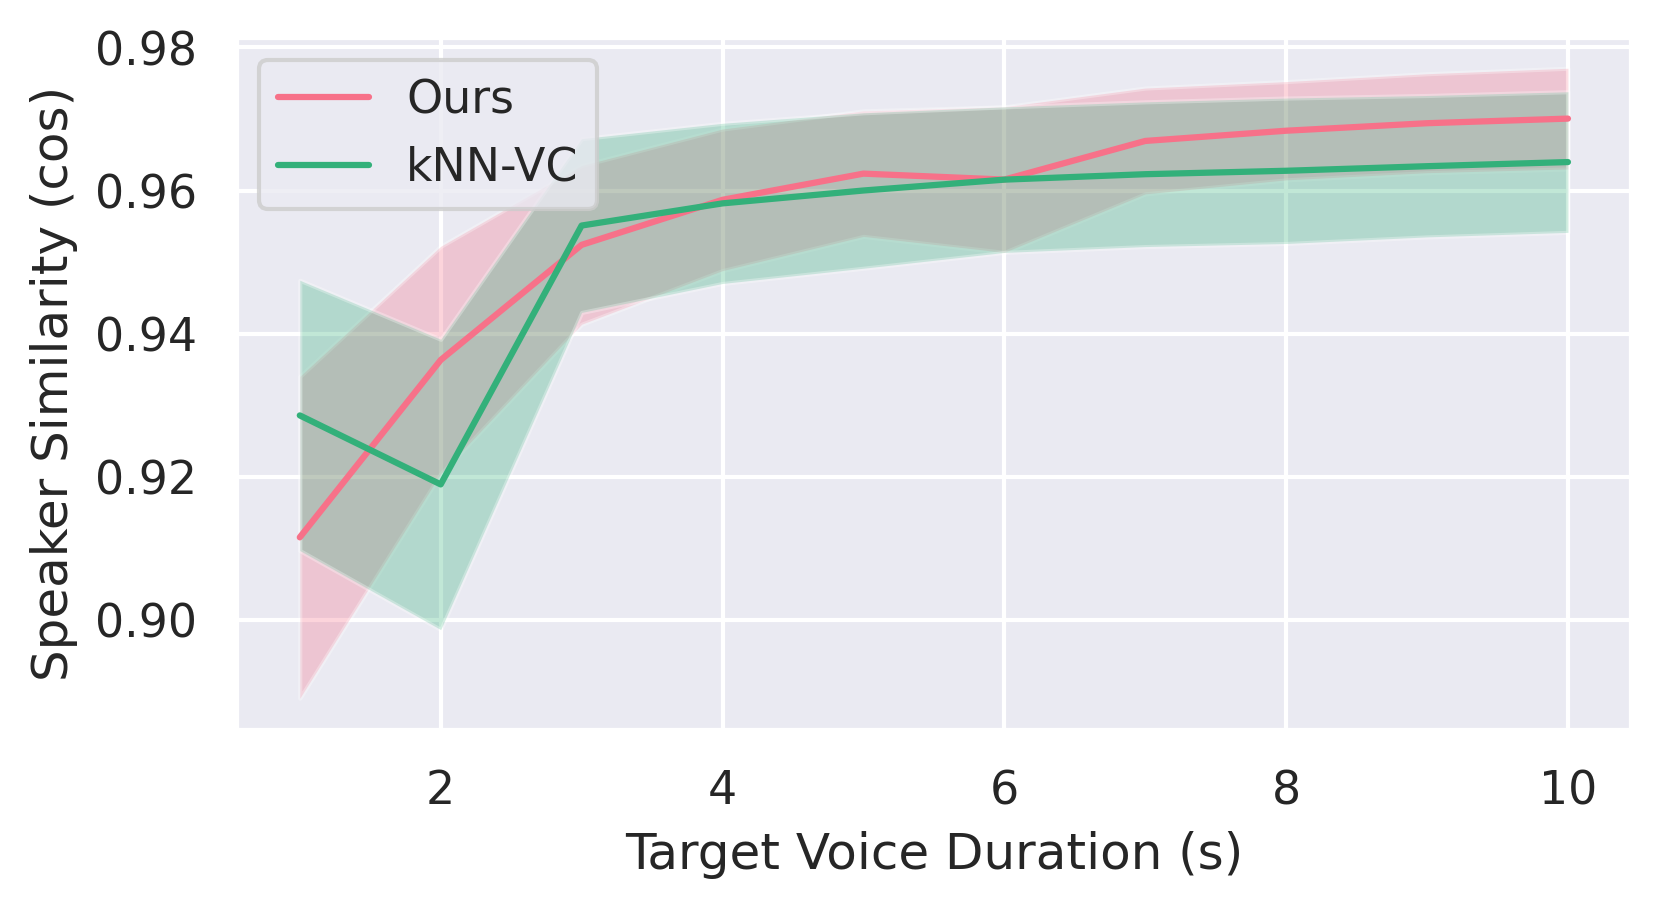

In [27]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sns.set(rc={'figure.figsize':(6,3),"figure.dpi":300, 'savefig.dpi':300})

fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
x = [1,2,3,4,5,6,7,8,9,10]

ours_sim_mean = np.array([0.9115, 0.9363, 0.9524, 0.9587, 0.96236, 0.961528, 0.96693, 0.96836, 0.96941, 0.970055])
ours_sim_std = np.array([0.0225, 0.0159, 0.0111, 0.0099, 0.00878,0.010178, 0.00740, 0.006872,0.006921,0.007041])

unexpand_sim_mean = np.array([0.9285526076617994, 0.9189,0.9551, 0.9582,0.9600, 0.96152, 0.96228, 0.96276,0.96340,0.963978])
unexpand_sim_std = np.array([0.0189, 0.0203, 0.01215, 0.0112,0.01087,0.010178, 0.01012,0.01017,0.009887,0.009834])

with sns.axes_style("darkgrid"):
    ax.plot(x, ours_sim_mean, label="Ours", c=clrs[0])
    ax.fill_between(x, ours_sim_mean-ours_sim_std, ours_sim_mean+ours_sim_std ,alpha=0.3, facecolor=clrs[0])
    ax.plot(x, unexpand_sim_mean, label="kNN-VC", c=clrs[2])
    ax.fill_between(x, unexpand_sim_mean-unexpand_sim_std, unexpand_sim_mean+unexpand_sim_std ,alpha=0.3, facecolor=clrs[2])
    ax.legend()
    #ax.set_yscale('log')
    ax.set(xlabel='Target Voice Duration (s)', ylabel='Speaker Similarity (cos)')
    

